In [1]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

from torch.optim import Adam
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

from livelossplot import PlotLosses
import copy
from nnet import *

In [ ]:
im = Image.open("data/train/Pause/20191027_023010_098.jpg")
im.show()

In [2]:
IMAGE_X = 50
IMAGE_Y = 50

TRAIN_DATA_PATH = './data/train/'

VALIDATION_SPLIT_SIZE = 0.1

BATCH_SIZE = 4
NUM_WORKERS = 2
SHUFFLE = True

LR = 0.01
EPOCH = 10

DROPOUT = 0.1

def get_binary(img_gray):
#     blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    thresh = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)[1]
#     gauss = cv2.GaussianBlur(img_gray, (5, 5), 0)
#     thresh = cv2.adaptiveThreshold(img_gray, 200, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 10)
    thresh = thresh[:,:,np.newaxis]
    return thresh

def add_channels(img):
    openCVim = np.array(img)
#     print(openCVim.shape)
    img_gray = cv2.cvtColor(openCVim, cv2.COLOR_BGR2GRAY)
#     thresh = get_binary(img_gray)
    img_gray = img_gray[:,:,np.newaxis]
    img_combined = np.concatenate((openCVim, img_gray), axis=2)
#     img_combined = np.concatenate((openCVim, img_gray, thresh), axis=2)
#     print("grayscale-correct: ", img_gray.shape)
#     print("threshold-correct: ", thresh.shape)
#     print("img_combined-correct: ", img_combined.shape)
#     print("grayscale: ", img_gray.shape)
#     print("threshold: ", thresh.shape)
#     print("img_combined: ", img_combined.shape)
    PILim = Image.fromarray(img_combined)

    return PILim

TRANSFORM = transforms.Compose(
[
    transforms.Lambda(add_channels),
transforms.Resize((IMAGE_X,IMAGE_Y)),
 transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))])
#  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
def load_dataset_from_folder():
    all_data = ImageFolder(
        root = TRAIN_DATA_PATH,
        transform = TRANSFORM
    )
    
    classes = all_data.classes
    print(all_data.class_to_idx)
    validation_size = int(VALIDATION_SPLIT_SIZE * len(all_data))
    train_size = len(all_data) - validation_size
    train_dataset, test_dataset = torch.utils.data.random_split(all_data, [train_size, validation_size])

    training_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=SHUFFLE
    )
    
    validation_dataset_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=SHUFFLE
    )
        
    return training_data_loader,validation_dataset_loader,classes


In [4]:
model = Net()

# Defining the optimizer
optimizer = Adam(model.parameters(), lr=LR)

# Defining the loss function
criterion = nn.CrossEntropyLoss()

# Checking if GPU is available
if torch.cuda.is_available():
    print('Found Cuda')
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): Dropout2d(p=0.1, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): Dropout2d(p=0.1, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.1, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=256, out_features=2048, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=2048, out_features=4, bias=True)
    (1): ReLU()
  )
  (sof): LogSoftmax()
)


In [5]:
train_generator,test_generator,classes = load_dataset_from_folder()
print(classes)
# for x,y in train_generator:
#     continue

{'Next': 0, 'Others': 1, 'Pause': 2, 'Prev': 3}
['Next', 'Others', 'Pause', 'Prev']


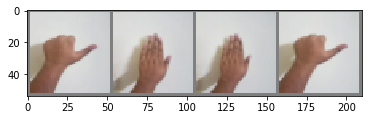

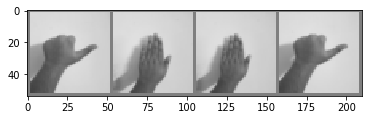

 Next Pause Pause  Next


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def get_rgb_img(tensor_batch):
    modif = tensor_batch[:,:3,:,:]
#     print(tensor_batch)
    return modif

def get_grayscale(tensor_batch):
    modif = tensor_batch[:,3:4,:,:]
    return modif

# def get_threshold(tensor_batch):
#     modif = tensor_batch[:,4:5,:,:]
#     return modif

# get some random training images
dataiter = iter(train_generator)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(get_rgb_img(images)))
imshow(torchvision.utils.make_grid(get_grayscale(images)))
# imshow(torchvision.utils.make_grid(get_threshold(images)))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

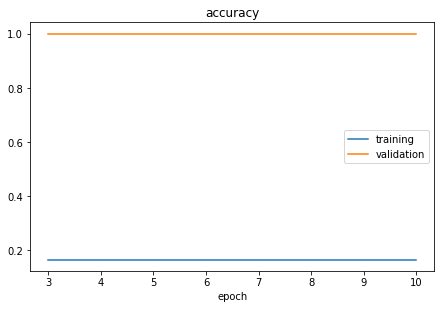

accuracy:
training   (min:    0.111, max:    0.167, cur:    0.167)
validation (min:    1.000, max:    1.000, cur:    1.000)


In [7]:
liveloss = PlotLosses()

for epoch in range(EPOCH):
    logs = {}

    running_loss = 0.0
    running_acc = 0.0
    for step,(x,y) in enumerate(train_generator):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y)
        
    epoch_acc = running_acc.float() / len(train_generator.dataset)

#     print('[%d] Training loss: %.3f' %(epoch + 1, running_loss))

#     logs['log loss'] = running_loss
    logs['accuracy'] = epoch_acc
    
    validation_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for step,(x,y) in enumerate(test_generator):
            outputs = model(x)
            loss = criterion(outputs, y)
            _, preds = torch.max(outputs, 1)
#             print(preds)
            validation_loss += loss.item()
            val_acc += torch.sum(preds == y)
#     print('[%d] Validation loss: %.3f' %(epoch + 1, validation_loss))
    
    val_fin_acc = val_acc.float() / len(test_generator.dataset)
#     logs['val_log loss'] = validation_loss
    logs['val_accuracy'] = val_fin_acc
    liveloss.update(logs)
    liveloss.draw()
    model.save("model/test_model")